In [1]:
import bioread
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
data = bioread.read_file('H:/Stimulacija_vagus_meritve_tok/tok_napetost01_02_22_16_00.acq')

In [3]:
napetost_data = None
tok_data = None

for channel in data.channels:
    if channel.name == 'Napetost':
        time_intervals = channel.time_index[1] - channel.time_index[0]
        sample_rate = 1.0 / time_intervals
        napetost_data = channel.data
    elif channel.name == 'Tok':
        tok_data = channel.data

In [11]:
sample_rate = int(round(sample_rate, 2))
sampling_rate = sample_rate

In [5]:
od_s = 924
do_s = 924.5


# fig = go.Figure()
# fig.add_trace(go.Scatter(  # X-axis as sample numbers
#     y=napetost_data[int(od_s*sample_rate):int(do_s*sample_rate)],  # First 1000 values of 'napetost'
#     mode='markers',  # Use markers for scatter plot
#     name='Napetost'
# ))
# fig.update_layout(
#     title="First 1000 Values of Napetost Channel (Scatter Plot)",
#     xaxis_title="Sample Number",
#     yaxis_title="Value"
# )
# fig.show()

In [6]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(  # X-axis as sample numbers
#     y=napetost_data[int(od_s*sample_rate):int(do_s*sample_rate)],  # First 1000 values of 'napetost'
#     mode='lines',  # Use markers for scatter plot
#     name='Napetost'
# ))
# fig.update_layout(
#     title="First 1000 Values of Napetost Channel (Scatter Plot)",
#     xaxis_title="Sample Number",
#     yaxis_title="Value"
# )
# fig.show()

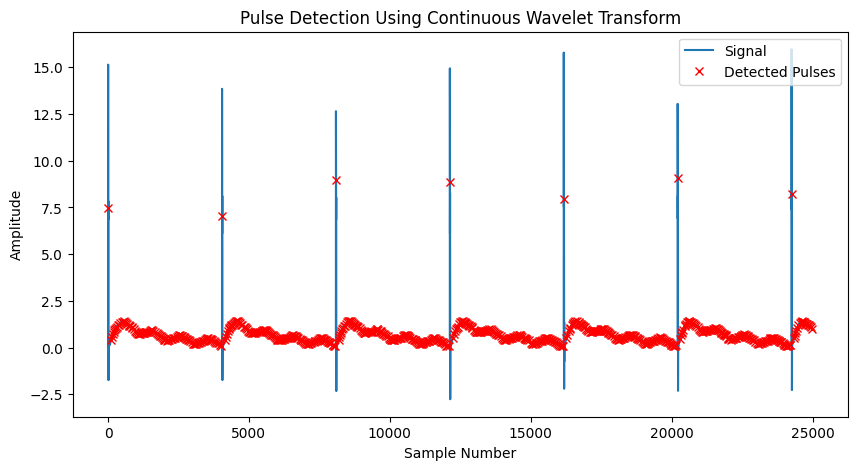

In [7]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt


# Add some baseline noise (simulating hysteresis)
synthetic_signal = napetost_data[int(od_s*sample_rate):int(do_s*sample_rate)]

# Continuous Wavelet Transform with Ricker (Mexican Hat) wavelet
widths = np.arange(1, 10)  # Range of scales to consider
cwt_matrix = signal.cwt(synthetic_signal, signal.ricker, widths)

# Find peaks in the wavelet coefficients at an optimal scale
# Choose a scale that highlights the pulses best (try with the last scale as example)
optimal_scale = cwt_matrix[-1]
peaks, _ = signal.find_peaks(optimal_scale, distance=10)  # Adjust distance for pulse width

# Plot the original signal and detected peaks
plt.figure(figsize=(10, 5))
plt.plot(synthetic_signal, label="Signal")
plt.plot(peaks, synthetic_signal[peaks], "x", color="red", label="Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Pulse Detection Using Continuous Wavelet Transform")
plt.show()

# Display detected pulse amplitudes
pulse_amplitudes = synthetic_signal[peaks]
#print("Detected pulse amplitudes:", pulse_amplitudes)

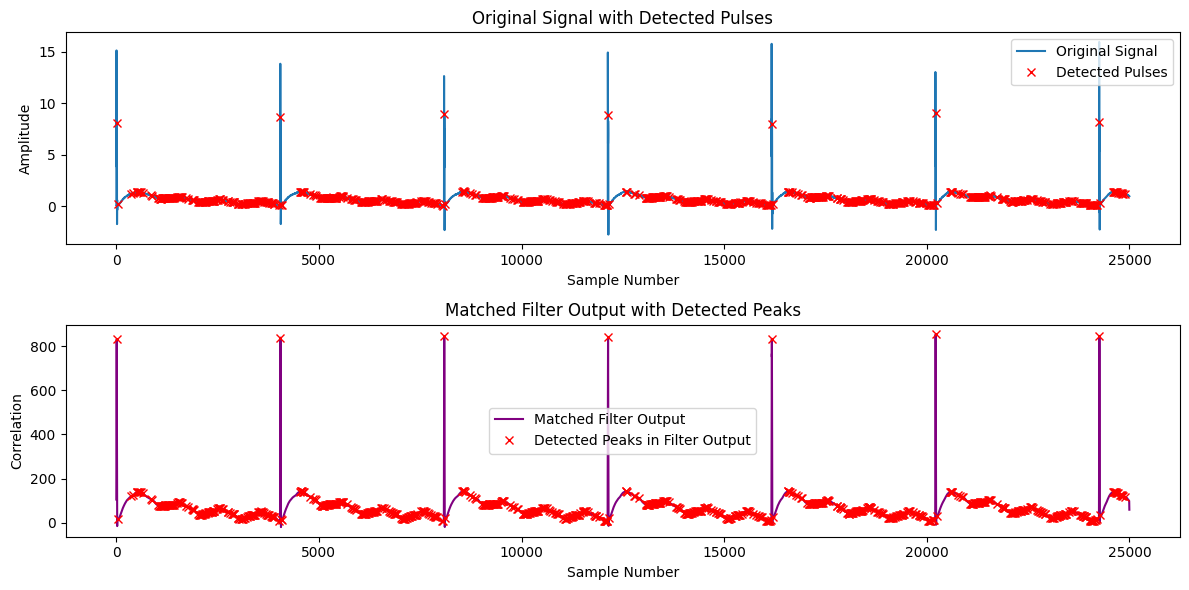

Detected pulse amplitudes: [8.07189941 0.16937256 1.19781494 1.23596191 1.37481689 1.39465332
 1.39770508 1.41143799 1.3885498  1.38244629 1.32141113 1.05895996
 1.02233887 0.78735352 0.75073242 0.73852539 0.74615479 0.74462891
 0.75073242 0.75378418 0.76293945 0.76904297 0.76293945 0.77056885
 0.77972412 0.79040527 0.79040527 0.80108643 0.8102417  0.80718994
 0.80718994 0.82092285 0.81939697 0.81939697 0.82550049 0.81939697
 0.82397461 0.82397461 0.91094971 0.93383789 0.93383789 0.93841553
 0.93841553 0.91552734 0.90789795 0.87585449 0.76141357 0.69885254
 0.61798096 0.60577393 0.59509277 0.57830811 0.39672852 0.37078857
 0.37384033 0.37231445 0.36621094 0.37384033 0.38452148 0.38299561
 0.40130615 0.41656494 0.42572021 0.44708252 0.45623779 0.46234131
 0.47454834 0.48217773 0.48675537 0.49438477 0.50506592 0.50201416
 0.51422119 0.51422119 0.52337646 0.51727295 0.62561035 0.6439209
 0.65460205 0.66833496 0.65765381 0.62408447 0.6072998  0.47454834
 0.4776001  0.43945312 0.39978027 0.

In [8]:
from scipy.signal import find_peaks, correlate


# Step 1: Create a pulse template (based on observed pulse characteristics)
# Adjust the template based on your data; here we're using a simple rectangular pulse
pulse_duration = 10  # Adjust as needed based on the pulse width in samples
pulse_amplitude = 10  # Typical pulse amplitude
pulse_template = np.ones(pulse_duration) * pulse_amplitude

# Step 2: Apply matched filtering (cross-correlation with the pulse template)
matched_filter_output = correlate(synthetic_signal, pulse_template, mode='same')

# Step 3: Use peak detection on the matched filter output to find pulse locations
# Peaks in this output represent locations with high correlation to the pulse template
peaks, _ = find_peaks(matched_filter_output, distance=pulse_duration)  # Adjust distance based on expected pulse separation

# Get the amplitude values at the detected peak locations from the original signal
pulse_amplitudes = synthetic_signal[peaks]

# Plot the original signal, matched filter output, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(2, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(peaks, synthetic_signal[peaks], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Matched filter output plot
plt.subplot(2, 1, 2)
plt.plot(matched_filter_output, label="Matched Filter Output", color="purple")
plt.plot(peaks, matched_filter_output[peaks], "x", color="red", label="Detected Peaks in Filter Output")
plt.xlabel("Sample Number")
plt.ylabel("Correlation")
plt.title("Matched Filter Output with Detected Peaks")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)

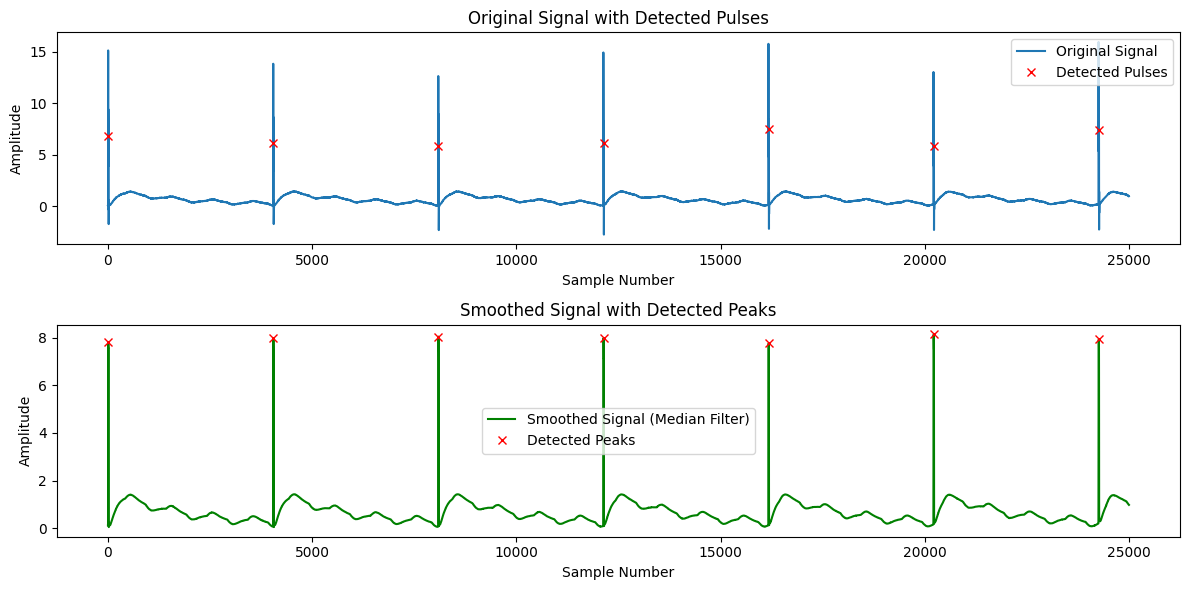

Detected pulse amplitudes: [6.83746338 6.10809326 5.80749512 6.09741211 7.52410889 5.88226318
 7.39898682]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import median_filter

# Step 1: Apply a median filter to smooth the signal
window_size = 11  # Adjust window size based on the noise level and pulse width
smoothed_signal = median_filter(synthetic_signal, size=window_size)

# Step 2: Detect local maxima in the smoothed signal
# The prominence parameter helps select peaks that stand out from the surrounding noise
peaks, _ = find_peaks(smoothed_signal, prominence=1.5)  # Adjust prominence as needed

# Extract pulse amplitudes from the original signal at detected peak locations
pulse_amplitudes = synthetic_signal[peaks]

# Plot the original signal, smoothed signal, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(2, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(peaks, synthetic_signal[peaks], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Smoothed signal plot
plt.subplot(2, 1, 2)
plt.plot(smoothed_signal, label="Smoothed Signal (Median Filter)", color="green")
plt.plot(peaks, smoothed_signal[peaks], "x", color="red", label="Detected Peaks")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Smoothed Signal with Detected Peaks")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)

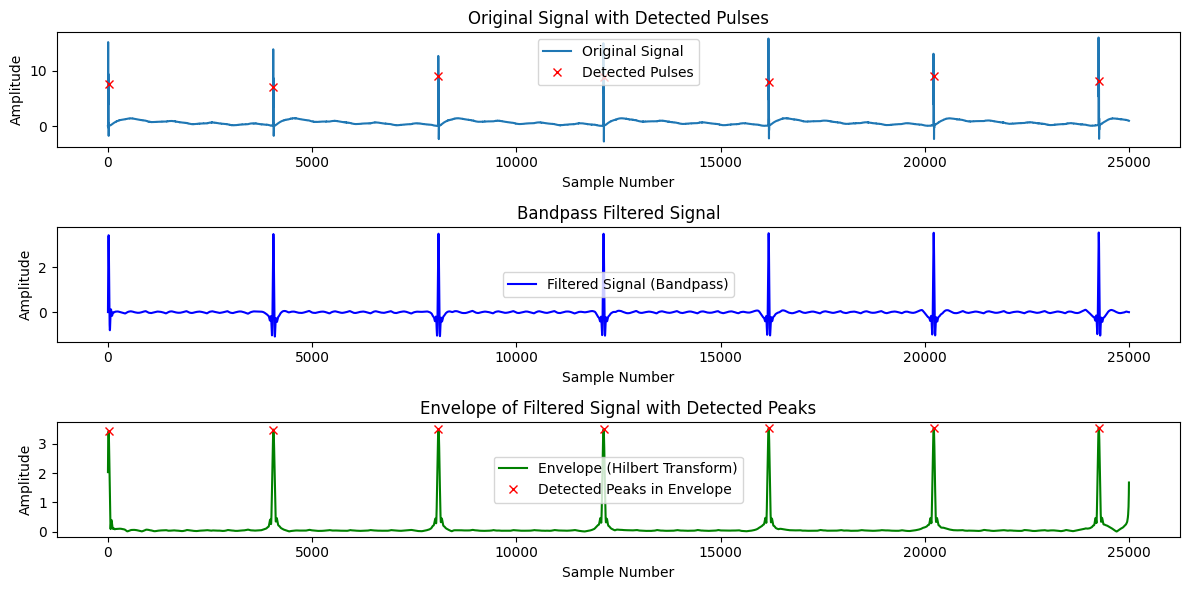

Detected pulse amplitudes: [7.54241943 7.03430176 8.9630127  8.84094238 7.96813965 9.07897949
 8.21838379]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, hilbert

# Assuming 'data' is your signal data loaded from the .acq file
# Replace `data` with your actual signal values

# Step 1: Bandpass filter design to isolate pulse frequencies
# Adjust the frequency range as per the expected pulse frequency content
lowcut = 100  # Lower bound of frequency (Hz)
highcut = 1000  # Upper bound of frequency (Hz)

# Create the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply the bandpass filter to the signal
filtered_signal = bandpass_filter(synthetic_signal, lowcut, highcut, sampling_rate)

# Step 2: Envelope detection using the Hilbert transform
analytic_signal = hilbert(filtered_signal)
envelope = np.abs(analytic_signal)

# Step 3: Detect peaks on the envelope
# Adjust the prominence parameter based on the signal characteristics
peaks, _ = find_peaks(envelope, prominence=1)  # Adjust prominence as needed

# Extract pulse amplitudes from the original signal at detected peak locations
pulse_amplitudes = synthetic_signal[peaks]

# Plot the original signal, envelope, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(3, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(peaks, synthetic_signal[peaks], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Filtered signal plot
plt.subplot(3, 1, 2)
plt.plot(filtered_signal, label="Filtered Signal (Bandpass)", color="blue")
plt.title("Bandpass Filtered Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Envelope plot with detected peaks
plt.subplot(3, 1, 3)
plt.plot(envelope, label="Envelope (Hilbert Transform)", color="green")
plt.plot(peaks, envelope[peaks], "x", color="red", label="Detected Peaks in Envelope")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Envelope of Filtered Signal with Detected Peaks")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)


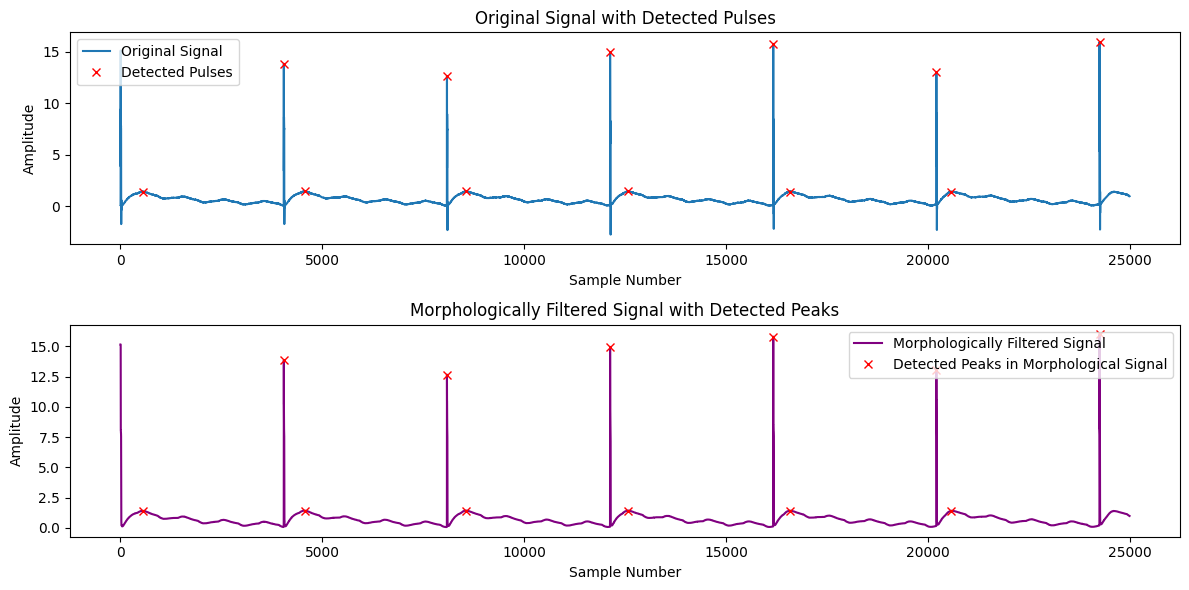

Detected pulse amplitudes: [ 1.4175415  13.85192871  1.43280029 12.65411377  1.43432617 14.94750977
  1.43280029 15.78979492  1.42364502 13.04779053  1.41601562 15.97137451]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import grey_dilation, grey_erosion

# Step 1: Apply morphological transformations
# Define the structuring element size based on the expected pulse width
structuring_element_size = 10  # Adjust based on pulse width

# Apply dilation to enhance pulses
dilated_signal = grey_dilation(synthetic_signal, size=structuring_element_size)

# Apply erosion to reduce noise and minor fluctuations
eroded_signal = grey_erosion(dilated_signal, size=structuring_element_size)

# Step 2: Detect peaks in the morphologically transformed signal
# Adjust the prominence parameter to focus on significant peaks
peaks, _ = find_peaks(eroded_signal, prominence=1)  # Adjust prominence as needed

# Extract pulse amplitudes from the original signal at detected peak locations
pulse_amplitudes = synthetic_signal[peaks]

# Plot the original signal, morphologically filtered signal, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(2, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(peaks, synthetic_signal[peaks], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Morphologically filtered signal plot
plt.subplot(2, 1, 2)
plt.plot(eroded_signal, label="Morphologically Filtered Signal", color="purple")
plt.plot(peaks, eroded_signal[peaks], "x", color="red", label="Detected Peaks in Morphological Signal")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Morphologically Filtered Signal with Detected Peaks")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)


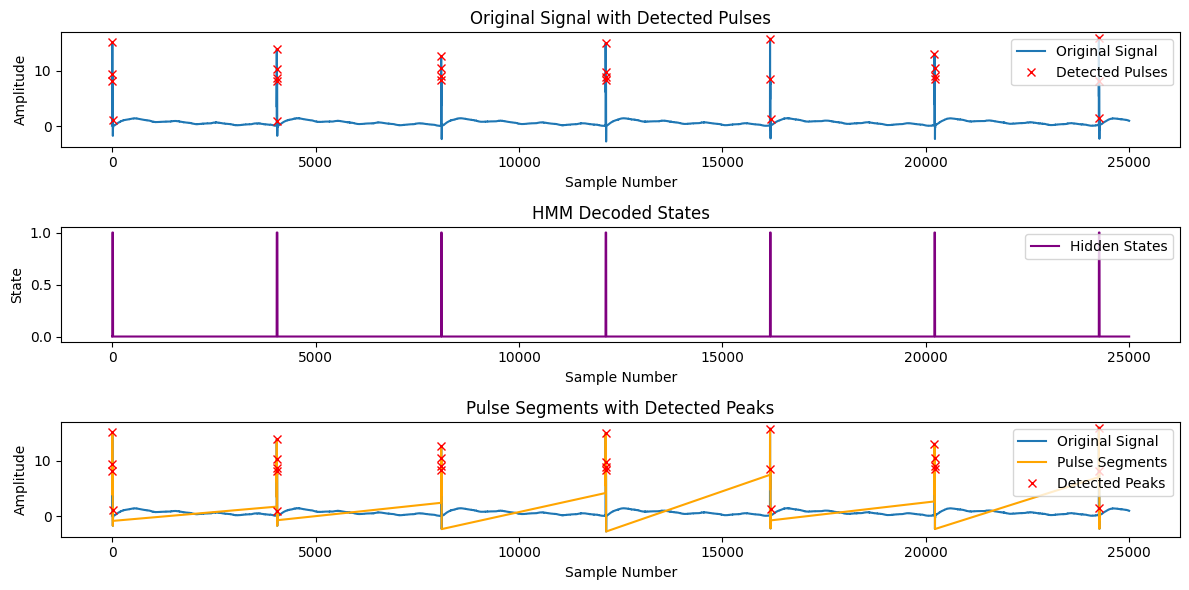

Detected pulse amplitudes: [15.14587402  9.44061279  8.07189941  1.18713379 13.85192871 10.24169922
  8.66699219  8.12225342  0.8605957  12.65411377 10.47363281  8.9630127
  8.3114624  14.94750977  9.72137451  8.84094238  8.29620361 15.78979492
  8.48083496  1.34277344 13.04779053 10.53924561  9.07897949  8.41674805
 15.97137451  8.21838379  1.41296387]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from scipy.signal import find_peaks

# Step 1: Prepare the data for HMM
# Reshape the signal as required by the HMM library (2D array)
signal_reshaped = synthetic_signal.reshape(-1, 1)

# Step 2: Define and train the Hidden Markov Model
# Configure the HMM with two states (pulse and background)
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=42)
model.fit(signal_reshaped)

# Step 3: Decode the hidden states to identify pulses
hidden_states = model.predict(signal_reshaped)

# Step 4: Locate pulse segments based on the hidden states
# Find the state with higher mean value (likely the "pulse" state)
state_means = [np.mean(synthetic_signal[hidden_states == i]) for i in range(model.n_components)]
pulse_state = np.argmax(state_means)

# Identify pulse indices where the model is in the pulse state
pulse_indices = np.where(hidden_states == pulse_state)[0]

# Step 5: Detect peaks in the pulse segments
# Use peak detection on the original signal at the identified pulse indices
peaks, _ = find_peaks(synthetic_signal[pulse_indices], prominence=1)  # Adjust prominence if needed
pulse_amplitudes = synthetic_signal[pulse_indices][peaks]

# Map peak locations back to the original signal indices
original_indices = pulse_indices[peaks]

# Plot the original signal, HMM decoded states, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(3, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(original_indices, synthetic_signal[original_indices], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# HMM state plot
plt.subplot(3, 1, 2)
plt.plot(hidden_states, label="Hidden States", color="purple")
plt.xlabel("Sample Number")
plt.ylabel("State")
plt.title("HMM Decoded States")
plt.legend()

# Detected pulse segments plot
plt.subplot(3, 1, 3)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(pulse_indices, synthetic_signal[pulse_indices], color="orange", label="Pulse Segments")
plt.plot(original_indices, synthetic_signal[original_indices], "x", color="red", label="Detected Peaks")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Pulse Segments with Detected Peaks")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)


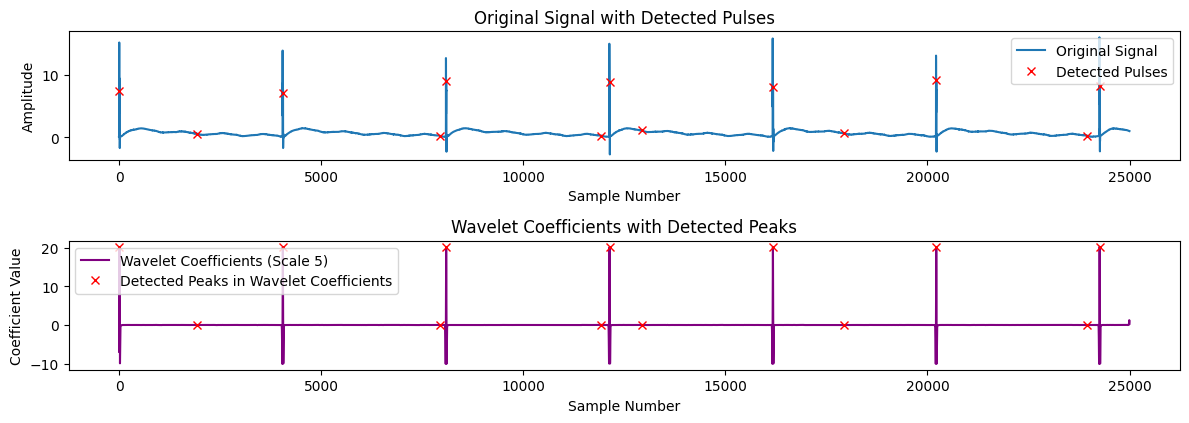

Detected pulse amplitudes: [7.45849609 0.56915283 7.03430176 0.24261475 8.9630127  0.25024414
 8.84094238 1.06811523 7.96813965 0.63018799 9.07897949 0.26092529
 8.21838379]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, cwt, ricker

# Step 1: Apply Continuous Wavelet Transform (CWT) using the Ricker (Mexican hat) wavelet
widths = np.arange(1, 20)  # Range of scales to explore; adjust based on pulse width
cwt_matrix = cwt(synthetic_signal, ricker, widths)

# Step 2: Choose the scale(s) with the highest response to pulses
# We'll examine a mid-range scale (e.g., widths[5]) as an example
selected_scale = 5
wavelet_coefficients = cwt_matrix[selected_scale]

# Step 3: Detect peaks in the wavelet coefficient signal
# The prominence parameter helps focus on significant features
peaks, _ = find_peaks(wavelet_coefficients, prominence=1)  # Adjust prominence as needed

# Map detected peaks back to the original signal to get amplitudes
pulse_amplitudes = synthetic_signal[peaks]

# Plot the original signal, wavelet coefficients, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(3, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(peaks, synthetic_signal[peaks], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Wavelet coefficient plot
plt.subplot(3, 1, 2)
plt.plot(wavelet_coefficients, label=f"Wavelet Coefficients (Scale {selected_scale})", color="purple")
plt.plot(peaks, wavelet_coefficients[peaks], "x", color="red", label="Detected Peaks in Wavelet Coefficients")
plt.xlabel("Sample Number")
plt.ylabel("Coefficient Value")
plt.title("Wavelet Coefficients with Detected Peaks")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)


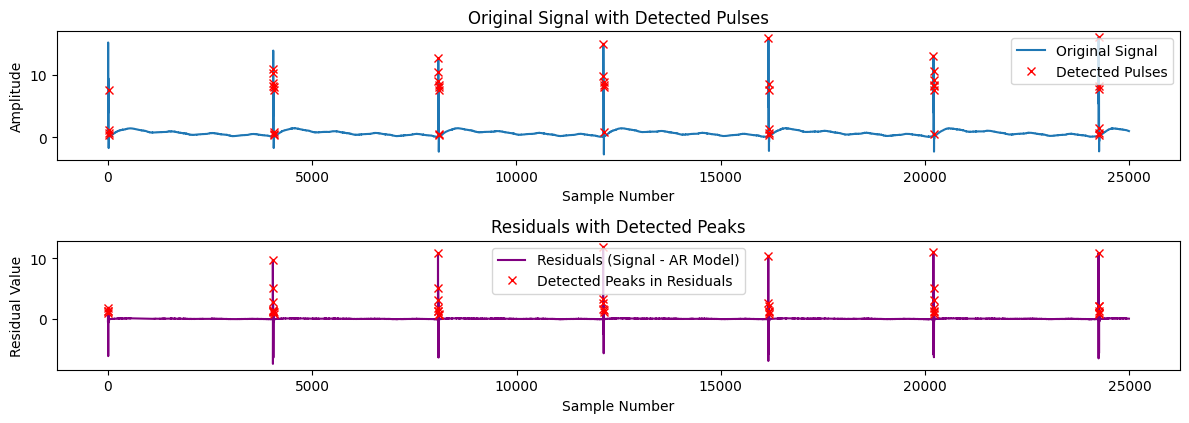

Detected pulse amplitudes: [ 7.54241943  1.18713379  0.59661865  0.3036499  10.97412109 10.24169922
  8.66699219  8.12225342  7.96813965  7.55157471  0.8605957   0.52947998
  0.29754639 12.65411377 10.47363281  8.9630127   8.3114624   8.04138184
  7.49053955  0.49591064  0.39978027 14.94750977  9.72137451  8.84094238
  8.29620361  7.98034668  0.78582764 15.78979492  8.48083496  7.59429932
  1.34277344  0.61187744  0.32958984 13.04779053 10.53924561  9.07897949
  8.41674805  8.13293457  7.56225586  0.46539307 15.97137451  8.18939209
  7.68127441  1.41296387  0.64697266  0.38909912]


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import find_peaks

# Step 1: Fit an AR model to the signal
lag = 10  # Set the AR model order based on signal characteristics
ar_model = AutoReg(synthetic_signal, lags=lag).fit()
ar_model_fitted_values = ar_model.predict(start=lag, end=len(synthetic_signal)-1)

# Step 2: Calculate residuals (differences between the AR model and the signal)
residuals = synthetic_signal[lag:] - ar_model_fitted_values

# Step 3: Detect peaks in the residuals
# Adjust prominence to focus on significant transients
peaks, _ = find_peaks(residuals, prominence=1)  # Adjust prominence as needed

# Map detected peaks back to the original signal to get amplitudes
pulse_indices = peaks + lag  # Offset by lag to align with original signal
pulse_amplitudes = synthetic_signal[pulse_indices]

# Plot the original signal, residuals, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(3, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(pulse_indices, synthetic_signal[pulse_indices], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Residuals plot
plt.subplot(3, 1, 2)
plt.plot(residuals, label="Residuals (Signal - AR Model)", color="purple")
plt.plot(peaks, residuals[peaks], "x", color="red", label="Detected Peaks in Residuals")
plt.xlabel("Sample Number")
plt.ylabel("Residual Value")
plt.title("Residuals with Detected Peaks")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)


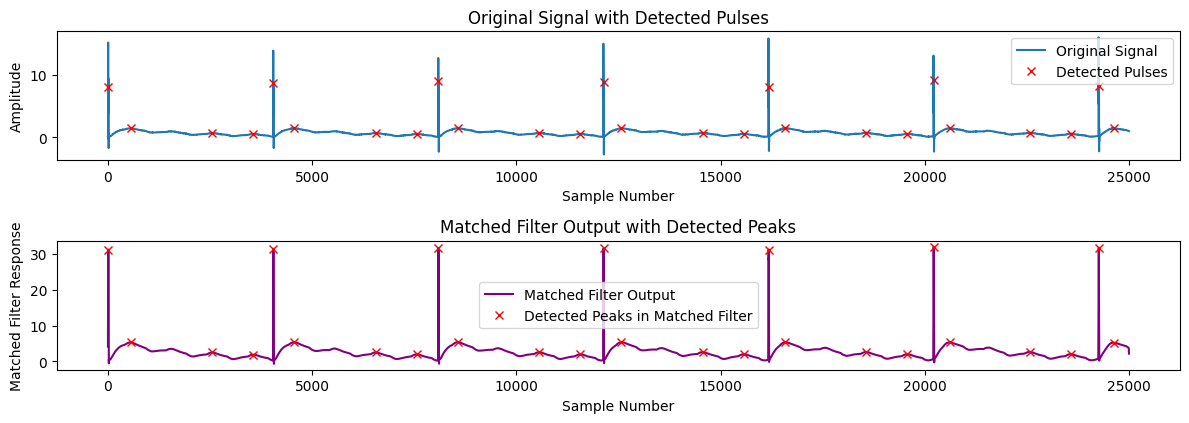

Detected pulse amplitudes: [8.07189941 1.41143799 0.66833496 0.50964355 8.66699219 1.42211914
 0.67596436 0.5279541  8.9630127  1.43280029 0.68359375 0.53253174
 8.84094238 1.42211914 0.68817139 0.5355835  7.96813965 1.42211914
 0.70495605 0.54016113 9.07897949 1.40380859 0.70495605 0.54779053
 8.21838379 1.3885498 ]


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate

# Step 1: Create a pulse template based on a known pulse in the signal
# Define the start and end of a known pulse segment in the signal
pulse_start = 100  # Adjust this based on where a clear pulse appears in your signal
pulse_end = 110    # Adjust this based on the pulse duration
pulse_template = synthetic_signal[pulse_start:pulse_end]

# Step 2: Apply matched filtering by convolving the signal with the template
matched_filter_output = correlate(synthetic_signal, pulse_template, mode="same")

# Step 3: Detect peaks in the matched filter output
# The prominence parameter helps to ignore minor peaks
peaks, _ = find_peaks(matched_filter_output, prominence=1)  # Adjust prominence as needed

# Map detected peaks back to the original signal to get amplitudes
pulse_amplitudes = synthetic_signal[peaks]

# Plot the original signal, matched filter output, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(3, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(peaks, synthetic_signal[peaks], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Matched filter output plot
plt.subplot(3, 1, 2)
plt.plot(matched_filter_output, label="Matched Filter Output", color="purple")
plt.plot(peaks, matched_filter_output[peaks], "x", color="red", label="Detected Peaks in Matched Filter")
plt.xlabel("Sample Number")
plt.ylabel("Matched Filter Response")
plt.title("Matched Filter Output with Detected Peaks")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)


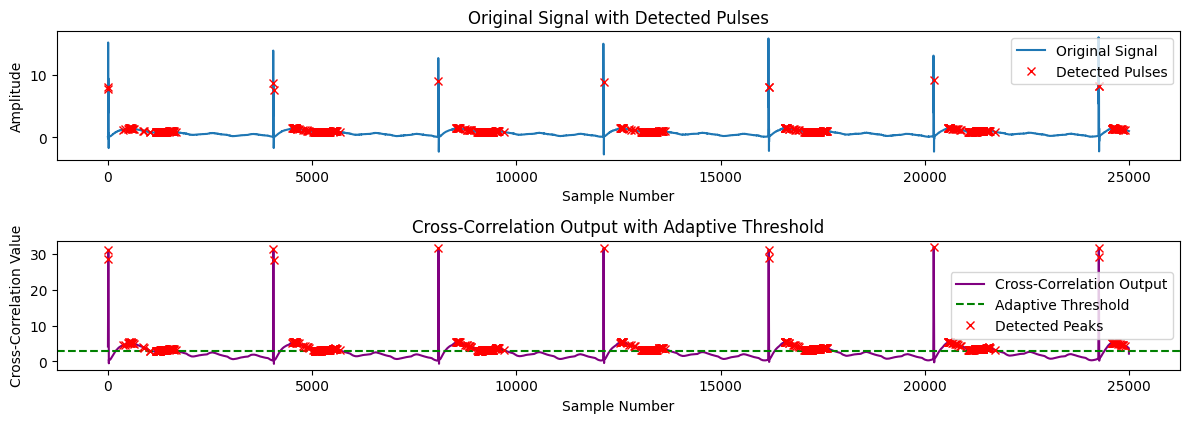

Detected pulse amplitudes: [8.07189941 7.68280029 1.19781494 1.23596191 1.37481689 1.39465332
 1.40838623 1.40075684 1.39770508 1.39770508 1.40533447 1.40380859
 1.41143799 1.3885498  1.38244629 1.37939453 1.32141113 1.05895996
 1.02233887 0.78735352 0.78582764 0.77362061 0.76751709 0.76293945
 0.77056885 0.78887939 0.78430176 0.77972412 0.79650879 0.79040527
 0.79040527 0.79040527 0.79650879 0.79345703 0.79956055 0.79040527
 0.8026123  0.8026123  0.8026123  0.80108643 0.79956055 0.80566406
 0.8102417  0.8102417  0.81176758 0.80718994 0.80871582 0.8102417
 0.82244873 0.80566406 0.81176758 0.82092285 0.81634521 0.81939697
 0.82092285 0.81939697 0.82550049 0.82092285 0.81939697 0.81329346
 0.82550049 0.81634521 0.82244873 0.81939697 0.80718994 0.81939697
 0.82092285 0.81176758 0.82397461 0.81939697 0.81939697 0.82244873
 0.8102417  0.81634521 0.82397461 0.90789795 0.91094971 0.93383789
 0.9262085  0.93841553 0.93231201 0.93383789 0.93231201 0.93383789
 0.93994141 0.93383789 0.93841553 0.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate

# Step 1: Create a pulse template based on a known pulse in the signal
# Define the start and end of a known pulse segment in the signal
pulse_start = 100  # Adjust this based on where a clear pulse appears in your signal
pulse_end = 110    # Adjust this based on the pulse duration
pulse_template = synthetic_signal[pulse_start:pulse_end]

# Step 2: Cross-correlate the signal with the template
cross_corr_output = correlate(synthetic_signal, pulse_template, mode="same")

# Step 3: Set an adaptive threshold based on the cross-correlation output’s statistical properties
threshold_factor = 1.5  # Adjust this based on signal characteristics
adaptive_threshold = threshold_factor * np.std(cross_corr_output)

# Step 4: Detect peaks above the adaptive threshold
# Only consider peaks above the adaptive threshold
peaks, _ = find_peaks(cross_corr_output, height=adaptive_threshold)

# Map detected peaks back to the original signal to get amplitudes
pulse_amplitudes = synthetic_signal[peaks]

# Plot the original signal, cross-correlation output, and detected pulses
plt.figure(figsize=(12, 6))

# Original signal plot
plt.subplot(3, 1, 1)
plt.plot(synthetic_signal, label="Original Signal")
plt.plot(peaks, synthetic_signal[peaks], "x", color="red", label="Detected Pulses")
plt.title("Original Signal with Detected Pulses")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

# Cross-correlation output plot
plt.subplot(3, 1, 2)
plt.plot(cross_corr_output, label="Cross-Correlation Output", color="purple")
plt.axhline(y=adaptive_threshold, color="green", linestyle="--", label="Adaptive Threshold")
plt.plot(peaks, cross_corr_output[peaks], "x", color="red", label="Detected Peaks")
plt.xlabel("Sample Number")
plt.ylabel("Cross-Correlation Value")
plt.title("Cross-Correlation Output with Adaptive Threshold")
plt.legend()

plt.tight_layout()
plt.show()

# Display detected pulse amplitudes
print("Detected pulse amplitudes:", pulse_amplitudes)
